In [14]:
import warnings
warnings.filterwarnings("ignore")
import sys,os
import numpy as np
import dicom
import glob
import matplotlib
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import time
import h5py
from sklearn import cross_validation
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras import backend as K
from os import environ
import keras
from keras.preprocessing import image

### Function to extract 3d image from the slices

In [18]:
def get_3d_data(p):
    path = INPUT_FOLDER + '\\' + p
    p1 = os.listdir(path)[0]
    p2 = os.listdir(path + '\\' + p1)
    files= os.listdir(path + '\\' + p1 + '\\' + p2[0]) 
    if len(files) > 1:
        slices = [dicom.read_file(path + '\\' +p1 + '\\' + p2[0] + '\\' + s) for s in os.listdir(path + '\\' +p1 + '\\' + p2[0])]
    else:
        slices = [dicom.read_file(path + '\\' +p1 + '\\' + p2[1] + '\\' + s) for s in os.listdir(path + '\\' +p1 + '\\' + p2[1])]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

## Functions for random augmentations

In [19]:
import scipy.ndimage
import random
def random_rotation(im):
    return scipy.ndimage.interpolation.rotate(im, angle=20, axes=(1, 2), reshape=False)

def random_shift(im):
    return scipy.ndimage.interpolation.shift(im, shift=10)

In [20]:
def random_augmentations(num_transformations_to_apply, image_to_transform):
    available_transformations = {
        'rotate': random_rotation,
        'shift': random_shift
        }

    if num_transformations_to_apply==1:
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
    else:
        transformed_image = random_rotation(image_to_transform)
        transformed_image = random_shift(transformed_image)
    return transformed_image

### Function to extract image cubes to be passed as input the CNN model

In [21]:
def get_image_cubes(patient):
    scan_img = get_3d_data(patient)
    scan_img[scan_img == -2000] = 0
    scan_img = random_augmentations(random.randint(1,2), scan_img)
    img_cubes = []
    for i in range(0, scan_img.shape[0] - 3, 3):
        tmp = []
        for j in range(3):
            img = scan_img[i + j] 
            img = 255.0 / np.amax(img) * img #Pixel Normalization
            img = cv2.equalizeHist(img.astype(np.uint8)) #Histogram equalization
            img = img.astype(np.uint8)
            img = img[50: 450, 50: 450] # Crop image
            img = cv2.resize(img, (224, 224))
            tmp.append(img)
        tmp = np.array(tmp)
        tmp = np.swapaxes(tmp,0,2)
        img_cubes.append(np.array(tmp))   
    img_cubes = np.array(img_cubes, dtype='int')
    return img_cubes

### Extract features from Inception model (pretrained imagenet weights)

In [22]:
from keras.models import Model
model = InceptionV3(weights='imagenet', include_top=True)
output = model.get_layer ('max_pooling2d_4').output
inc_model = Model(model.input, output)

In [23]:
INPUT_FOLDER = '.\\NSCLC-Radiomics\\'
patients = os.listdir(INPUT_FOLDER)
model = ResNet50(weights='imagenet', include_top=False)
for patient in patients:
    a= get_image_cubes(patient)
    feat_fold = '.\\inception_features_with_augmentations\\'
    feats = inc_model.predict(img_cubes, verbose=1)
    feats = np.mean(feats,axis=0).flatten() # Average pool & Flatten operation
    np.save(os.path.join(feat_fold, patient), feats)
    break

### Splitting training and test dataset (Maintaining the same data distribution)

In [24]:
import pandas as pd
dat_all=pd.read_csv('dat_all.csv')
import random
class1 = list(dat_all[dat_all['class']==0]['PatientID'])
class2 = list(dat_all[dat_all['class']==1]['PatientID'])
class1_test = class1[0:int((len(class1)) * 0.2)]
class2_test = class2[0:int((len(class2)) * 0.2)]
test_data = class1_test + class2_test 
train_data = [x for x in dat_all['PatientID'] if x not in test_data]
train_data_labels =[]
for a in train_data:
    train_data_labels.append(list(dat_all[dat_all['PatientID']==a]['class'])[0])
test_data_labels = []
for a in test_data:
    test_data_labels.append(list(dat_all[dat_all['PatientID']==a]['class'])[0])

### Add random augmentations of images from minority class (an approach to balance the dataset) to original dataset

In [25]:
x1 = [np.load('./inception_cnn_features/' + idd + '.npy') for idd in train_data]
x1_aug = [np.load('./inc_cnn_augmentations/' + idd + '.npy') for idd in train_data]
y1= l= train_data_labels
for a in [n for n,x in enumerate(l) if x== 1]:
    x1.append(x1[a])
    y1.append(train_data_labels[a])
x1= np.array(x1)
y1= np.array(y1)

In [26]:
encoder = LabelEncoder()
encoder.fit(y1)
encoded_Y = encoder.transform(y1)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

### Train Concolution model on features from maxpooling layer in inception model

In [52]:
def create_model():   
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(25,25,192)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    sgd = SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [27]:
model = create_model()

In [24]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=10**-7, patience=5, verbose=1, mode='auto'),
                ModelCheckpoint('lung_cancer_lifetime_inceptions_augmentations.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)]
history=model.fit(x1,dummy_y, steps_per_epoch= 800,validation_steps=10, epochs=20, verbose=1, validation_split=0.2, shuffle= True, callbacks=callbacks)

Train on 540 samples, validate on 136 samples
Epoch 1/20
800/800 [==============================] - 405s 507ms/step - loss: 1.2389 - acc: 0.4726 - val_loss: 0.9968 - val_acc: 0.4191

Epoch 00001: val_loss improved from inf to 0.99677, saving model to lung_cancer_lifetime_inceptions_augmentations.h5
Epoch 2/20
800/800 [==============================] - 506s 633ms/step - loss: 1.0017 - acc: 0.6338 - val_loss: 0.9305 - val_acc: 0.5221

Epoch 00002: val_loss improved from 0.99677 to 0.93052, saving model to lung_cancer_lifetime_inceptions_augmentations.h5
Epoch 3/20
800/800 [==============================] - 515s 644ms/step - loss: 0.8128 - acc: 0.7413 - val_loss: 0.7953 - val_acc: 0.6324

Epoch 00003: val_loss improved from 0.93052 to 0.79531, saving model to lung_cancer_lifetime_inceptions_augmentations.h5
Epoch 4/20
800/800 [==============================] - 553s 692ms/step - loss: 0.6190 - acc: 0.8305 - val_loss: 0.6959 - val_acc: 0.7132

Epoch 00004: val_loss improved from 0.79531 to 

['acc', 'loss', 'val_acc', 'val_loss']


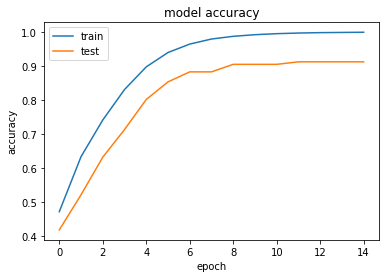

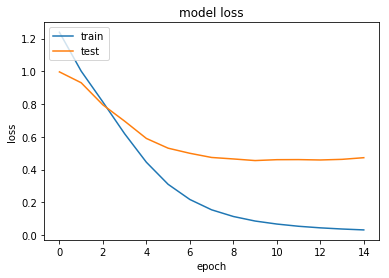

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating Model on test data

In [27]:
test_x = np.array([np.load('./inc_cnn_augmentations/' + idd + '.npy') for idd in test_data])
test_y = np.array(test_data_labels)

In [28]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(test_y)
encoded_Y = encoder.transform(test_y)
dummy_test_y = np_utils.to_categorical(encoded_Y)

In [29]:
print (model.evaluate(test_x,dummy_test_y, verbose=1))

print (model.metrics_names)

84/84 [==============================] - 0s 546us/step
[0.9549581209818522, 0.7857142871334439]
['loss', 'acc']


In [30]:
y_pred_keras = model.predict_proba(test_x)

In [31]:
y_pred =[]
for a in y_pred_keras:
    if a[0] > a[1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
y_pred = np.array(y_pred)

### ROC curve

In [32]:
from sklearn.metrics import roc_curve, auc
y_pred_keras = model.predict_proba(test_x)
fpr_keras_resnet, tpr_keras_resnet, thresholds_keras = roc_curve(test_y.ravel(), y_pred.ravel())
roc_auc = auc(fpr_keras_resnet, tpr_keras_resnet)

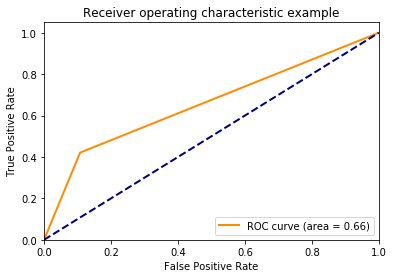

In [33]:
plt.figure()
lw = 2
plt.plot(fpr_keras_resnet, tpr_keras_resnet, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### ROC-AUC Confidence intervals

In [28]:
from sklearn.metrics import roc_auc_score
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.random_integers(0, len(y_pred.ravel()) - 1, len(y_pred.ravel()))
    if len(np.unique(test_y.ravel()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(test_y.ravel()[indices], y_pred.ravel()[indices])
    bootstrapped_scores.append(score)

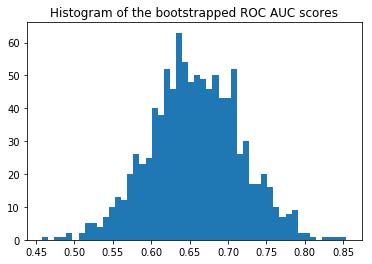

In [30]:
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [31]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()


# 95% confidence interval.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print (confidence_lower)
print (confidence_upper)

0.54296388543
0.777085927771


### Confusion Matrix

[[0.89230769 0.10769231]
 [0.57894737 0.42105263]]


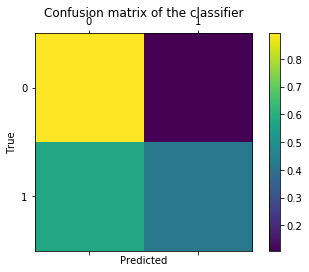

In [35]:
preds = []
for a in y_pred_keras:
    if a[0] > a[1]:
        preds.append(0)
    else:
        preds.append(1)
from sklearn.metrics import confusion_matrix

labels = [0, 1]
cm = confusion_matrix(test_data_labels, preds, labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()